## TP3

## Restauration d'image à l'aide de l'ADMM

## 1 Altération d'une image

1.3 Illustration

In [44]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse.linalg as slv
from time import time

data = pickle.load(open('data2018forpython2.pk','rb'))

original = data.get('original')
observations = data.get('observations')
filtre = data.get('filtre')
H = np.squeeze(np.asarray(data.get('H').todense()))
T = np.squeeze(np.asarray(data.get('T').todense()))

Observation du flou


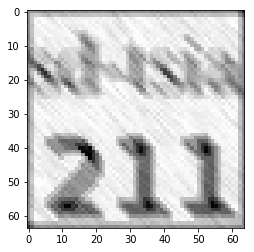

In [45]:
plt.imshow(observations, cmap='gray')
plt.show()

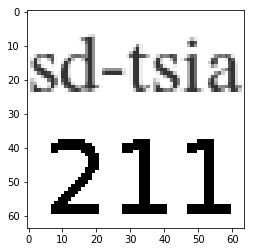

In [46]:
plt.imshow(original, cmap='gray')
plt.show()

## 2 - Algorithme ADMM

### Restauration d'image

#### Préparations 1 et 2 :  Lagrangien augmenté

In [65]:
%%latex
On chercher à minimiser $\frac{1}{2}||y-Hx||^2_2+\beta||Tx||_1+\iota_{[0,1]^P}(x)$
$$\\$$
On a $z=[z_1^T z_2^T]^T$ avec $z_1=x$ et $z_2=Tx$.
$$\\$$
On pose $f(x)=\frac{1}{2}||y-Hx||^2_2$ et $g(z)=\beta||z_2||_1+\iota_{[0,1]^P}(z_1)$
$$\\$$
$f$ et $g$ sont bien convexes car ce sont des normes. On peut prouver le caractère convexe de ces fonctions par inégalité triangulaire.
$$\\$$
Le problème se reformule donc en :
    $$\\$$
    Minimiser $f(x) + g(z)$ avec $Ax=z$
    où $f$ et $g$ sont définies comme précédemment et 
    $A=\left(
  \begin{array}
     \ I_p\\
        T
  \end{array} \right)
$ 
$$\\$$
On calcule maintenant le Lagrangien augmenté du problème. $$\\$$
On a $L_p(x,z^k,\gamma^k)=f(x)+g(z)+\gamma^T(Ax-z)+\frac{\rho}{2}||Ax-z||^2_2$
$$\\$$
Avec les expressions prédécentes on a donc :
    $$\\$$
    $L_p(x,z^k,\gamma^k)=\frac{1}{2}||y-Hx||^2_2+\beta||z_2||_1+\iota_{[0,1]^P}(z_1)+\gamma^T(\left(
  \begin{array}
     \ x\\
        Tx
  \end{array}\right)-z)+\frac{\rho}{2}||\left(\begin{array}
     \ x\\
        Tx
  \end{array}\right)-z||^2_2$

<IPython.core.display.Latex object>

#### Préparation 3 : Minimisation selon x

In [66]:
%%latex
Pour minimiser le lagrangien par rapport à x on va calculer les dérivées partielles.$$\\$$
On a : $$\\$$
    $\frac{\partial L_p}{\partial x}=H^T(Hx-y)+A^T\gamma+\rho.A^T(Ax-z)$
$$\\$$
Ainsi, pour minimiser le lagrangien on cherche $x$ tel que $\frac{\partial L_p}{\partial x}=0$
$$\\$$
On a donc $x^{k+1}$ tel que : $(H^TH+{\rho}A^TA)x^{k+1}=H^Ty-A^T\gamma+{\rho}A^Tz$

<IPython.core.display.Latex object>

#### Préparation 4 : Minimisation selon z1

In [67]:
%%latex
On souhaite minimiser par rapport à $z_1$ on a, par définition : $$\\$$
    $z^{k+1}_1=\underset{z_1}{\operatorname{argmin}} L_p(x^{k+1},z,\gamma^k)$
$$\\$$
Donc on a : 
    $z_1^{k+1}=\underset{z_1}{\operatorname{argmin}} \iota_{[0,1]^p}(z_1)-<\gamma_1^{k+1},z_1>+\frac{\rho}{2}||x^{k+1}-z_1||^2$
$$\\$$
On a :
$-<\gamma_1^{k+1},z_1>+\frac{\rho}{2}||x^{k+1}-z_1||^2=\frac{\rho}{2}||z_1||^2-\rho<x^{k+1},z_1>+\frac{\rho}{2}||x^{k+1}||^2-<\gamma^{k+1},z_1>$
$$\\$$
Puis on a : $\frac{\rho}{2}||z_1||^2-<{\rho}x^{k+1}+\gamma_1^k,z_1>+\frac{\rho}{2}||x^{k+1}||^2=\frac{\rho}{2}||\frac{1}{\rho}({\rho}x^{k+1}+\gamma_1^k)-z_1||^2-\frac{\rho}{2}||\frac{1}{\rho}({\rho}x^{k+1}+\gamma^k_1)||^2+\frac{\rho}{2}||x^{k+1}||^2$
    $$\\$$
    Donc on a $-<\gamma_1^{k+1},z_1>+\frac{\rho}{2}||x^{k+1}-z_1||^2=\frac{\rho}{2}||\frac{1}{\rho}({\rho}x^{k+1}+\gamma_1^k)-z_1||^2-\frac{\rho}{2}||\frac{1}{\rho}({\rho}x^{k+1}+\gamma^k_1)||^2+\frac{\rho}{2}||x^{k+1}||^2$
    $$\\$$
    Dans le membre de droite, seul le premier terme dépend de $z_1$ donc on a :
        $$\\$$
        $z_1^{k+1}=\underset{z_1}{\operatorname{argmin}} \frac{1}{\rho}\iota_{[0,1]^p}(z_1)+\frac{1}{2}||\frac{1}{\rho}({\rho}x^{k+1}+\gamma^k_1)-z_1||^2$
        $$\\$$
        Par définition de l'opérateur proximal on a : $$\\$$
        $z_1^{k+1}=prox_{\frac{1}{\rho}\iota_[0,1]^p}(x^{k+1}+\frac{1}{\rho}\gamma_1^k)$

<IPython.core.display.Latex object>

#### Minimisation selon z2

In [68]:
%%latex
Avec le même raisonnement que dans le cas précédent on a : $$\\$$
    $z^{k+1}_2=\underset{z_2}{\operatorname{argmin}} L_p(x^{k+1},z,\gamma^k)$
$$\\$$
Donc on a : 
    $z_2^{k+1}=\underset{z_2}{\operatorname{argmin}} \beta||z_2||^2-<\gamma_2^{k+1},z_2>+\frac{\rho}{2}||Tx^{k+1}-z_2||^2$
$$\\$$

On calcule l'opérateur proximal et on a :
$z_2^{k+1}=prox_{\beta||T.||_1}(Tx+\frac{1}{2}\gamma_1)$


<IPython.core.display.Latex object>

#### Préparation 5

In [73]:
%%latex
Par définition on a : $$\\$$
    $\gamma^{k+1}=\gamma^{k}+\rho(Ax^{k+1}-z^{k+1})$
    $$\\$$
    Donc on a : $$\\$$
        $\gamma_1^{k+1}=\gamma_1^{k}+\rho(Ax^{k+1}-z_1^{k+1})$
        $$\\$$ Et: $$\\$$
        $\gamma_2^{k+1}=\gamma_2^{k}+\rho(Ax^{k+1}-z_2^{k+1})$

<IPython.core.display.Latex object>

## 3 - Implémentation de l'ADMM pour résoudre le problème de restauration d'image

In [47]:
#Création des fonctions de calcul

def x_k(gamma, z1, z2, y, A, H, rho, left_side):
    z = np.concatenate((z1, z2), axis=0)
    right_side = np.dot(H.T,y) - np.dot(A.T, gamma) + rho*np.dot(A.T, z)
    #we chose to compute it outside because it is heavy
    #left_side = np.dot(H.T, H) + rho*np.dot(A.T, A)
    x = slv.cg(left_side, right_side)
    #print("Done with x_k")
    return x[0]

def z1_k(gamma1, rho, x):
    z1 = (1/rho)*gamma1 + x
    i = z1.shape[0]
    for j in range(0, i):
        if z1[j] < 0:
            z1[j] = 0
        elif z1[j] > 1:
            z1[j] = 1
    #print("Done with z1_k")
    return z1

def z2_k(gamma2, T, x, rho, beta):
    i = gamma2.shape[0]
    z2 = np.zeros(i)
    B = np.dot(T,x)
    first_cond = (1/rho)*(gamma2 - beta) + B
    second_cond = (1/rho)*(gamma2 + beta) + B
    for j in range(0, i):
        if first_cond[j] > 0:
            z2[j] = first_cond[j]
        elif second_cond[j] < 0:
            z2[j] = second_cond[j]
        else : 
            z2[j] = 0
    #print("Done with z2_k")
    return z2
            
def gamma_k(gamma1, gamma2, rho, x, z1, z2, T):
    gamma1 = gamma1 + rho*(x - z1)
    gamma2 = gamma2 + rho*(np.dot(T, x) - z2)
    gamma = np.concatenate((gamma1, gamma2))
    #print("Done with gamma_k")
    return gamma1, gamma2, gamma

#Implémentation de l'ADMM

def ADMM(gamma1, gamma2, rho, A, y, z1, z2, T, H, beta, kmax):
    gamma = np.concatenate((gamma1, gamma2))
    z = np.concatenate((z1, z2))
    left_side = np.dot(H.T, H) + rho*np.dot(A.T, A)
    for i in range(0,kmax+1):
        x = x_k(gamma, z1, z2, y, A, H, rho, left_side)
        z1 = z1_k(gamma1, rho, x)
        z2 = z2_k(gamma2, T, x, rho, beta)
        gamma1, gamma2, gamma = gamma_k(gamma1, gamma2, rho, x, z1, z2, T)
        #print("Done with ", i)
    return x

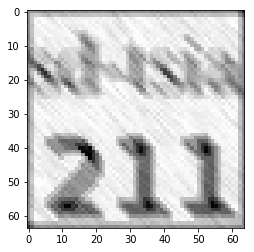

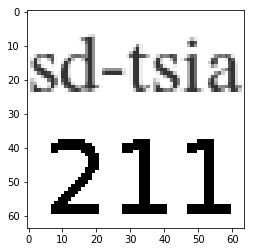

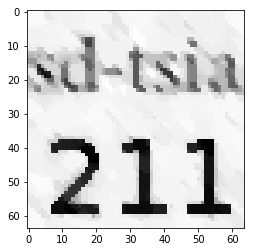

In [48]:
# Paramètres

rho = 0.05
beta = 0.01
kmax = 100

# Execution

x = observations.ravel()
gamma1 = z1 = np.zeros(x.shape[0])
gamma2 = z2 = np.zeros((np.dot(T,x)).shape[0])
I = np.eye(x.shape[0])
A = np.concatenate((I,T), axis = 0)
result = ADMM(gamma1, gamma2, rho, A, x, z1, z2, T, H, beta, kmax)
plt.imshow(observations, cmap='gray')
plt.show()
plt.imshow(original, cmap='gray')
plt.show()
plt.imshow(np.reshape(result, (64,64)), cmap='gray')
plt.show()

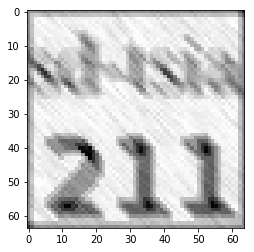

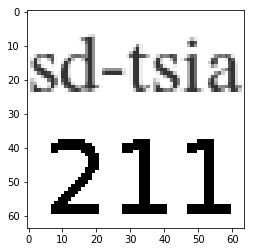

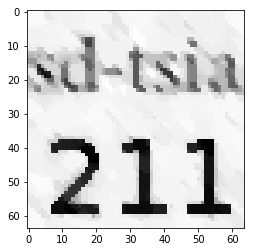

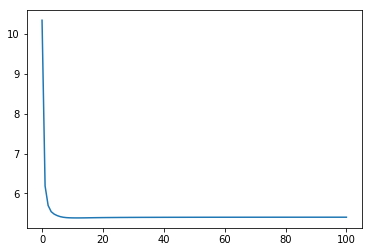

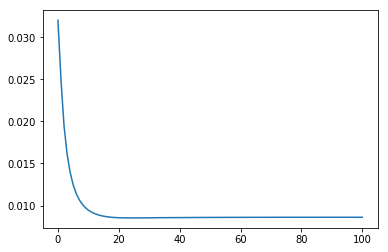

In [49]:
# Implémentation de l'ADMM avec suivi du lagrangien et MSE

def calcul_lagrangien(x, z1, z2, gamma1, gamma2, rho, y, H, A, beta):
    gamma = np.concatenate((gamma1,gamma2))
    z = np.concatenate((z1,z2))
    lag = 0
    lag = lag + 0.5 * (np.linalg.norm(y - np.dot(H,x))**2)
    lag = lag + beta * np.sum(np.absolute(z2))
    lag = lag + np.dot(gamma, np.dot(A,x)-z)
    lag = lag + 0.5 * rho * (np.linalg.norm(np.dot(A,x)-z)**2)
    return lag 

# Ajout du calcul du suivi du lagrangien et MSE

def ADMM_lag_MSE(gamma1, gamma2, rho, A, y, z1, z2, T, H, beta, kmax, original):
    start = time()
    lagrangien = []
    MSE= []
    gamma = np.concatenate((gamma1, gamma2))
    z = np.concatenate((z1, z2))
    left_side = np.dot(H.T, H) + rho*np.dot(A.T, A)
    for i in range(0,kmax+1):
        x = x_k(gamma, z1, z2, y, A, H, rho, left_side)
        z1 = z1_k(gamma1, rho, x)
        z2 = z2_k(gamma2, T, x, rho, beta)
        gamma1, gamma2, gamma = gamma_k(gamma1, gamma2, rho, x, z1, z2, T)
        MSE += [np.mean((x-original)**2)]
        lagrangien += [calcul_lagrangien(x, z1, z2, gamma1, gamma2, rho, y, H, A, beta)]
    temps = time()-start
    return x, MSE, lagrangien, temps

result, MSE, Lagrangien, temps = ADMM_lag_MSE(gamma1, gamma2, rho, A, x, z1, z2, T, H, beta, kmax, original.ravel())
plt.imshow(observations, cmap='gray')
plt.show()
plt.imshow(original, cmap='gray')
plt.show()
plt.imshow(np.reshape(result, (64,64)), cmap='gray')
plt.show()
plt.plot(Lagrangien)
plt.show()
plt.plot(MSE)
plt.show()

On observe que le lagrangien décroit rapidement et reste constant durant environ 90 itérations. De même pour le MSE qui met un peu plus de temps à se stabiliser (constant à 80 itérations). Cela est satisfaisant car cela témoigne d'une absence de chemin à exploiter pour l'algorithme. 

In [39]:
MSE[len(MSE)-1]

0.0086074991154287631

On trouve un biais de 0.0086074991154287631

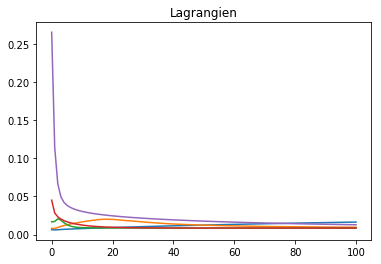

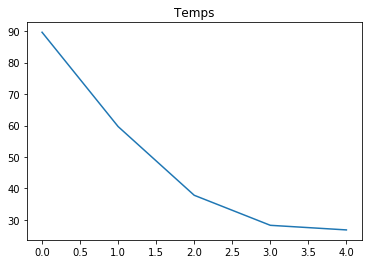

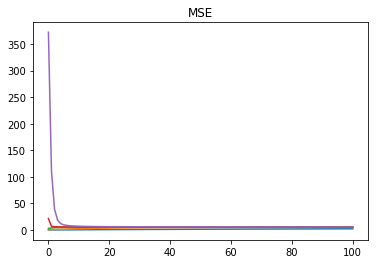

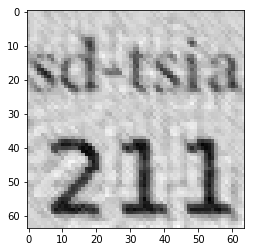

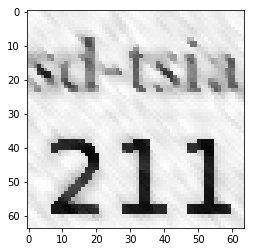

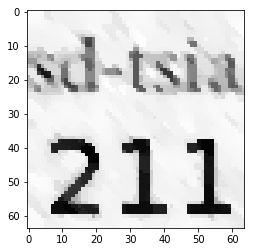

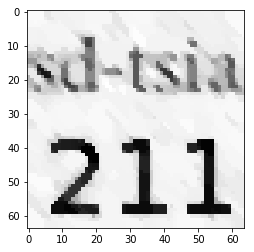

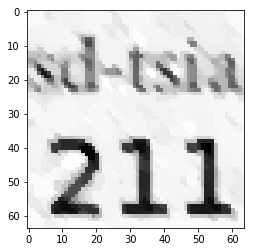

In [61]:
# Etude avec différent rho

# Paramètres

beta = 0.01
kmax = 100

# Execution

x = observations.ravel()
gamma1 = z1 = np.zeros(x.shape[0])
gamma2 = z2 = np.zeros((np.dot(T,x)).shape[0])
I = np.eye(x.shape[0])
A = np.concatenate((I,T), axis = 0)

# On modifie les ADMM afin d'avoir le temps

list_rho = [1e-4, 1e-3, 1e-2, 1e-1, 1]
list_Lagrangien = []
list_result = []
list_MSE = []
list_time = []

for j in list_rho:
    result, Lagrangien, MSE, temps = ADMM_lag_MSE(gamma1, gamma2, j, A, x, z1, z2, T, H, beta, kmax, original.ravel())
    list_Lagrangien += [Lagrangien]
    list_MSE += [MSE]
    list_result += [result]
    list_time += [temps]
    
# Affichage résultats
for x in list_Lagrangien:
    plt.plot(x)
plt.title("Lagrangien")
plt.show()
plt.plot(list_time)
plt.title("Temps")
plt.show()
for x in list_MSE:
    plt.plot(x)
plt.title("MSE")
plt.show()
for x in list_result:
    plt.imshow(np.reshape(x, (64,64)), cmap='gray')
    plt.show()


Quand rho est très petit, l'algorithme semble ne pas prendre une bonne direction de descente. Il converve quand même. Cela a un fort impact sur les images et MSE.

En dehors de la proximité de zéro, rho n'a que peu d'impact sur la qualité de l'image ; plus rho est grand, plus le temps de calcul est court ; plus rho est grand, moins le langrangien décroit vite ; plus rho est grand, plus la MSE décroit lentement. 

Cela a du sens étant donné que rho ne sert qu'à la convexité du lagrangien. 


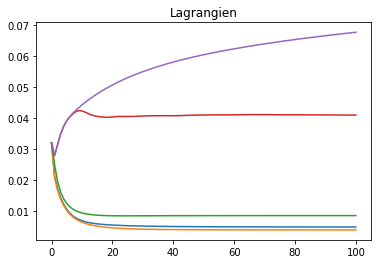

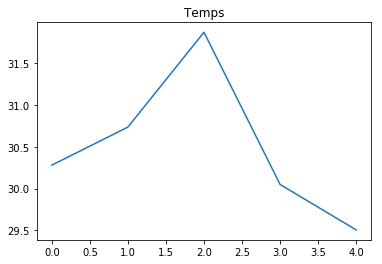

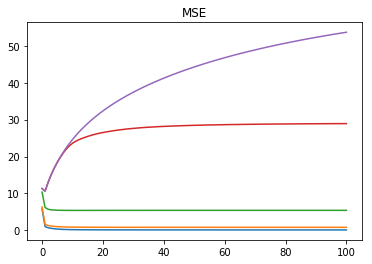

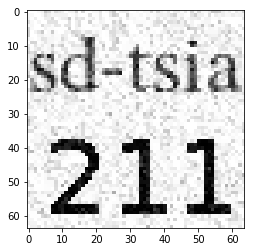

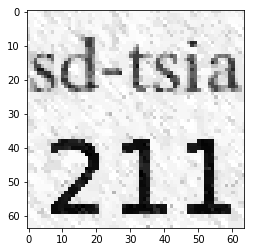

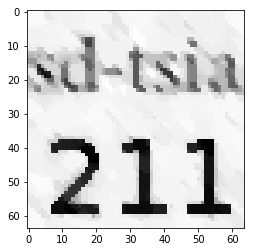

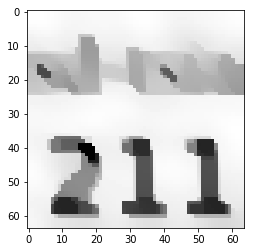

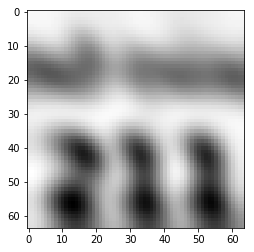

In [63]:
# Etude avec différent beta

# Paramètres

rho = 0.05
kmax = 100

# Execution

x = observations.ravel()
gamma1 = z1 = np.zeros(x.shape[0])
gamma2 = z2 = np.zeros((np.dot(T,x)).shape[0])
I = np.eye(x.shape[0])
A = np.concatenate((I,T), axis = 0)

# On modifie les ADMM afin d'avoir le temps

list_beta = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
list_Lagrangien = []
list_result = []
list_MSE = []
list_time = []

for j in list_rho:
    result, Lagrangien, MSE, temps = ADMM_lag_MSE(gamma1, gamma2, rho, A, x, z1, z2, T, H, j, kmax, original.ravel())
    list_Lagrangien += [Lagrangien]
    list_MSE += [MSE]
    list_result += [result]
    list_time += [temps]
    
# Affichage résultats
for x in list_Lagrangien:
    plt.plot(x)
plt.title("Lagrangien")
plt.show()
plt.plot(list_time)
plt.title("Temps")
plt.show()
for x in list_MSE:
    plt.plot(x)
plt.title(r"MSE")
plt.show()
for x in list_result:
    plt.imshow(np.reshape(x, (64,64)), cmap='gray')
    plt.show()


D'après nos observations, plus beta est élevé, plus la figure est lisse ; la valeur idéal semble 0.01, cela correspond au minimum du lagrangien ; le temps augmente beaucoup avec beta ; laMSE augmente avec beta. 
